# Classification of articles based on their content

For completely analyzing the text data we need to call in a few packages in python that come in handy for manipulation of the text.

In [108]:
import numpy as np
import nltk, re, unicodedata
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.model_selection import train_test_split
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import os
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
print os.listdir('./')

Downloading the required documentations.

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/miremadaghili/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/miremadaghili/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/miremadaghili/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

First we load the data that we collected from the <strong><em>General Relativity and Gravittation Journal</em></strong>:

In [39]:
with open('grg_abstract.txt', 'r') as grg_f:
    grg_abstracts = [line.decode('utf-8').split('\n')[0] for line in grg_f if len(line)>1]

In [40]:
grg_abstracts[:5]

[u'A simple unified closed form derivation of the non-linearities of the Einstein, Yang-Mills and spinless (e.g. chiral) meson systems is given. For the first two, the non-linearities are required by locality and consistency; in all cases, they are determined by the conserved currents associated with the initial (linear) gauge invariance of the first kind. Use of first-order formalism leads uniformly to a simple cubic self-interaction.',
 u'In an ingenious way rotation (but no angular momentum) has been introduced in the case of spherical symmetry by Einstein, who has considered a stationary cluster of particles moving freely under the influence of the gravitational field produced by all of them together. The aim of the present work is to extend his idea to the non-static case, and it seems that under some circumstances instead of an indefinite gravitational collapse there is a minimum of the volume and a bouncing back.',
 u'The Friedmann and Kantowski-Sachs models of the universe are 

And then we load the data that we previousely obtained from the <strong><em>European Physical Journal C</em></strong>:

In [41]:
with open('./contents.txt', 'r') as epjc_f:
    epjc_abstracts = [line.decode('utf-8').split('\n')[0] for line in epjc_f]

In [42]:
epjc_abstracts[:3]

[u'"A framework associating quantum cosmological boundary conditions to minisuperspace hidden symmetries has been introduced in Jalalzadeh and Moniz (Phys Rev D 89:083504, 2014). The scope of the application was, notwithstanding the novelty, restrictive because it lacked a discussion involving realistic matter fields. Therefore, in the present letter, we extend the framework scope to encompass elements from a scalar\u2013tensor theory in the presence of a cosmological constant. More precisely, it is shown that hidden minisuperspace symmetries present in a pre-big bang model suggest a process from which boundary conditions can be selected."',
 u'"A detailed study of top-quark polarizations and charge asymmetries, induced by top-squark-pair production at the LHC and the subsequent decays , is performed within the effective description of squark interactions, which includes the effective Yukawa couplings and another logarithmic term encoding the supersymmetry breaking. This effective appr

Before we start processing the text, we look at the two classes and their distribution to see if the classes are actually skewed.

In [43]:
print 'grg percentage: ', len(grg_abstracts)*1./(len(grg_abstracts)+len(epjc_abstracts))
print 'epjc percentage: ',len(epjc_abstracts)*1./(len(grg_abstracts)+len(epjc_abstracts))

grg percentage:  0.584477930391
epjc percentage:  0.415522069609


The class weights are actually not too far from eachother, therefore, at the first step we will not try to balance the data and we go streight for tokenizing the texts.<br>
For the next step we will create a list of words from the abstracts, and using the stoppingwords method in nltk, we will remove the commonly used words that will not help our model such as "is".

To clean the text we define some functions that will come in handy. We start by getting rid of the punctuations, non-asci charachters, and traces of html.

In [44]:
def html_remover(text):
    '''Remove the html characters
    text: string'''
    text = BeautifulSoup(text, 'html.parser')
    return text.get_text()
def punctuation_remover(text):
    '''Removes punctuations
    text: string'''
    text = re.sub(r'[^\w\s]', '', text)
    return text

def clean(text):
    '''apply the cleaning on the text
    text: string'''
    text = html_remover(text)
    text = punctuation_remover(text)
    return text

In [45]:
cleaned_grg = [clean(abstract) for abstract in grg_abstracts if clean(abstract) != '']
cleaned_epjc = [clean(abstract) for abstract in epjc_abstracts if clean(abstract) != '']

After cleaning the whole abstracts, we need to tokenize the words and while we are doing that we should remove any extra element such as non-ascii characters, and the words that are not stop words. For this we define our new set of functions.

In [46]:
def tokenize(text):
    '''Tokenizing the text
    text: string or a list of strings'''
    if type(text) is str:
        text = word_tokenize(text)
        return text
    if type(text) is list:
        lst = []
        for txt in text:
            lst += word_tokenize(txt)
        return lst
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words
    words: list or an array"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words
def remove_stopwords(words):
    '''Removing the stopwords
    words: list'''
    new_words = [word.lower() for word in words if word.lower() not in stopwords.words('english')]
    return new_words
def separated(text):
    '''Applying tokenization procedure
    text: string or list of strings'''
    text = tokenize(text)
    text = remove_stopwords(text)
    text = remove_non_ascii(text)
    return text

In [47]:
tokenized_grg = separated(cleaned_grg)
tokenized_epjc = separated(cleaned_epjc)

## Visualization and Comparison

Now we visualize the text of the articles from the two journals and look at the differences. To visualize we use the **frequency distributions** and the **word clouds**.

### General Relativity and Gravitation

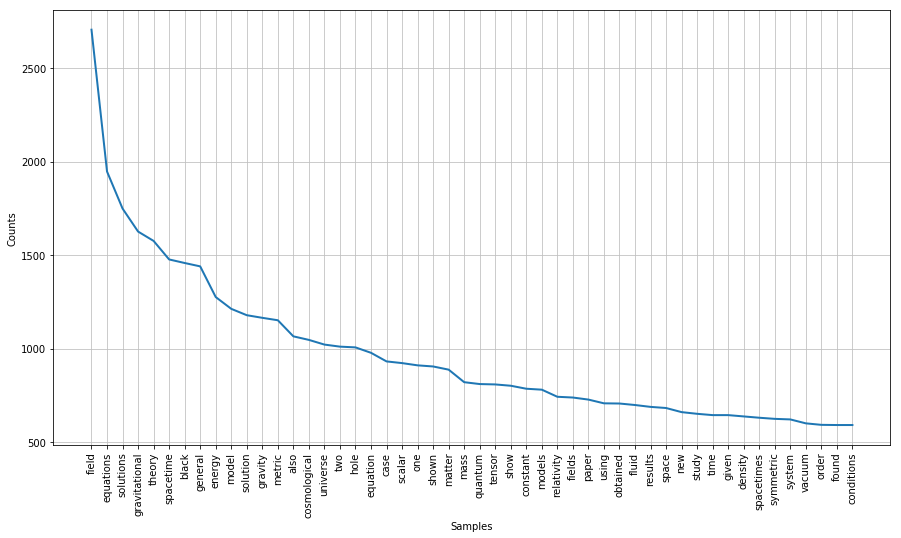

<Figure size 432x288 with 0 Axes>

In [150]:
GRG_freq_dist = nltk.FreqDist(tokenized_grg)
plt.figure(figsize = (15, 8))
GRG_freq_dist.plot(50)
plt.savefig('GRG_FreqDist.pdf')

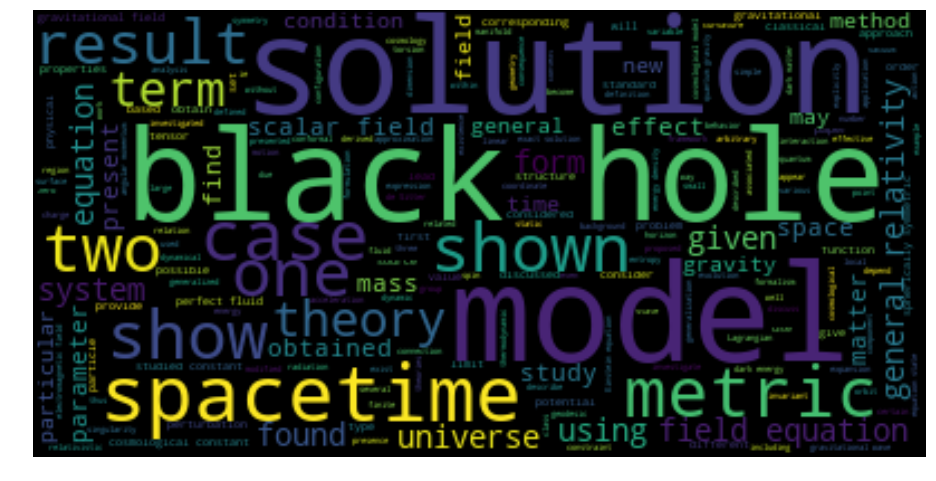

In [151]:
grg_str = ''
for abstract in cleaned_grg:
    grg_str += abstract
wordcloud = WordCloud(max_font_size=60).generate(grg_str)
plt.figure(figsize=(16,12))
# plot wordcloud in matplotlib
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('GRG_WordCloud.pdf')
plt.show()

### European Physical Journal C

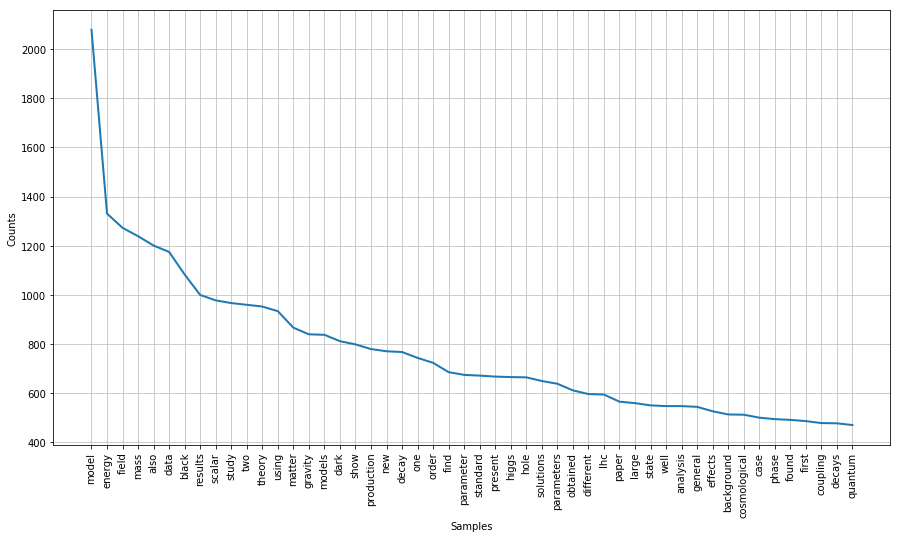

<Figure size 432x288 with 0 Axes>

In [148]:
EPJC_freq_dist = nltk.FreqDist(tokenized_epjc)
plt.figure(figsize = (15, 8))
EPJC_freq_dist.plot(50)
plt.savefig('EPJC_FreqDist.pdf')

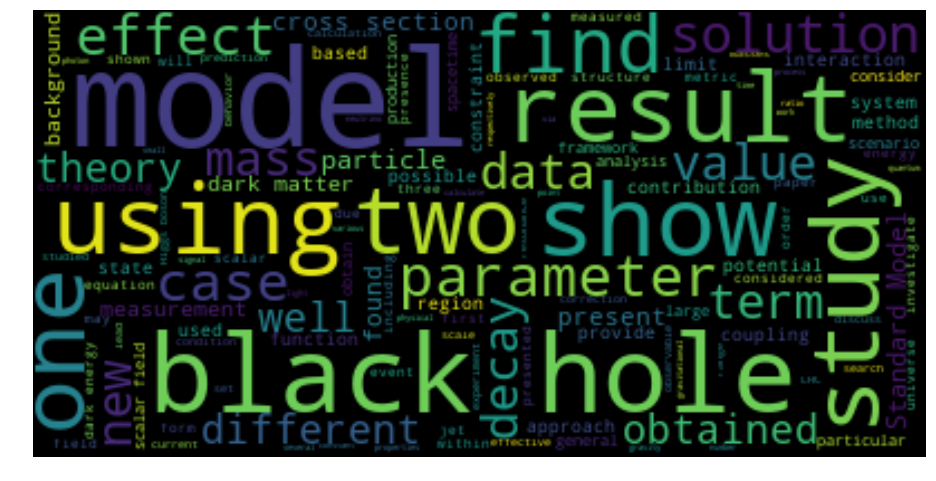

In [149]:
epjc_str = ''
for abstract in cleaned_epjc:
    epjc_str += abstract
    
wordcloud = WordCloud(max_font_size=60).generate(epjc_str)
plt.figure(figsize=(16,12))
# plot wordcloud in matplotlib
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('EPJC_WordCloud.pdf')
plt.show()

## Lemmatizing and Stemming

We see that some words like black hole and model are frequent in both of the journals, but the other words are reasonably different. Now we turn our attention into classifying the abstracts.

In [49]:
all_words = tokenized_grg + tokenized_epjc
all_abstracts = cleaned_grg + cleaned_epjc

In [50]:
lemmatizer = WordNetLemmatizer()
sp = PorterStemmer()
stem_lst = [sp.stem(word) for word in all_words]
lemma_lst = [lemmatizer.lemmatize(word) for word in all_words]

We look at the fequency of different words.

In [32]:
print len(cleaned_grg), len(cleaned_epjc)

4383 3116


The classes are reasonably close in number, so at the first step there is no worries about having a skewed data.

For the rest of our calculations we are going to only use a postion of the features (5000) to make the calculations possible.

In [33]:
stem_word_features = nltk.FreqDist(stem_lst).keys()[:5000]
lemma_word_features = nltk.FreqDist(lemma_lst).keys()[:5000]

Let us define a function that gets the text and the featurelins and returns a dictionary shows which features the text has.

In [52]:
def feature_finder(text, features, T):
    '''This function is creating a feature list'''
    if T == 'stem':
        ps = PorterStemmer()
        text_words = [ps.stem(w) for w in word_tokenize(text)]
    else:
        lemmatizer = WordNetLemmatizer()
        text_words = [lemmatizer.lemmatize(w) for w in word_tokenize(text)]
    lst = {}
    for word in features:
        lst[word] = (word in text_words)
    return lst

In [54]:
stem_Data = [feature_finder(abstract, stem_word_features, 'stem') for abstract in all_abstracts]

Let's define the labels. We are going to use 1 for <strong>GRG</strong> articles and 0 for <strong>EPJC</strong> articles.

In [55]:
labels = [1]*len(grg_abstracts)+[0]*len(epjc_abstracts)

### Slicing the data
We devide the data into training ans testing sets to be able to check the performance of the model, and make sure our model does not overfit or underfit the data.

In [56]:
X_train, X_test, y_train, y_test = train_test_split(stem_Data, labels,
                                                    test_size = .1, random_state = 0)

In [57]:
stem_train = [(X_train[i],y_train[i]) for i in range(len(X_train))]

In [58]:
classifier = nltk.NaiveBayesClassifier.train(stem_train)

In [59]:
stem_test = [(X_test[i], y_test[i]) for i in range(len(X_test))]
print 'NaiveBayesClassifier accuracy with stemming:', nltk.classify.accuracy(classifier, stem_test)*100

NaiveBayesClassifier accuracy with stemming: 79.2


Now let's look and see how much lemmatization help the classification.

In [62]:
Lemma_data = [feature_finder(abstract, lemma_word_features, 'lemma') for abstract in all_abstracts]

In [63]:
X_train, X_test, y_train, y_test = train_test_split(stem_Data, labels,
                                                    test_size = .1, random_state = 0)

In [64]:
lemma_train = [(X_train[i], y_train[i]) for i in range(len(X_train))]
lemma_test = [(X_test[i], y_test[i]) for i in range(len(X_test))]

In [65]:
lemma_classifier = nltk.NaiveBayesClassifier.train(lemma_train)

In [66]:
print 'NaiveBayesClassifier accuracy with lemmatization: ', nltk.classify.accuracy(lemma_classifier, lemma_test)*100

NaiveBayesClassifier accuracy with lemmatization:  79.2


Same value for accuracy. Now we look at the dispersion plot of some of the words that are likely to be used.

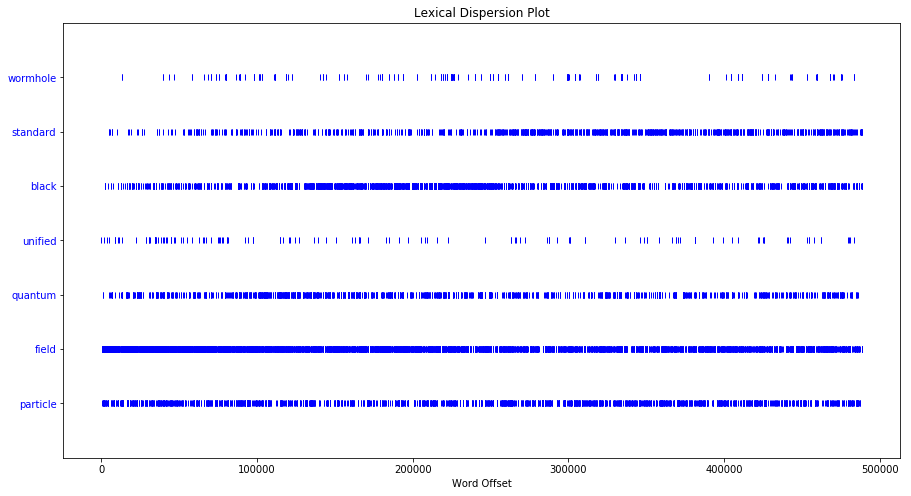

<Figure size 432x288 with 0 Axes>

In [147]:
plt.figure(figsize=(15, 8))
nltk.draw.dispersion_plot(lemma_lst, ['wormhole', 'standard', 'black', 'unified', 'quantum', 'field', 'particle'])
plt.savefig('LexicalDisspersion.pdf')

In [74]:
lemma_classifier.show_most_informative_features(15)

Most Informative Features
                     jet = True                0 : 1      =    106.0 : 1.0
                   width = True                0 : 1      =     56.8 : 1.0
                     pdf = True                0 : 1      =     51.3 : 1.0
              semilepton = True                0 : 1      =     43.8 : 1.0
                      95 = True                0 : 1      =     41.5 : 1.0
                      cm = True                0 : 1      =     36.9 : 1.0
                    muon = True                0 : 1      =     30.3 : 1.0
                 inelast = True                0 : 1      =     28.7 : 1.0
                  collid = True                0 : 1      =     28.6 : 1.0
                    2016 = True                0 : 1      =     27.4 : 1.0
                  confid = True                0 : 1      =     19.7 : 1.0
                   resum = True                0 : 1      =     19.3 : 1.0
                    cern = True                0 : 1      =     18.9 : 1.0

To see if we can do any better than this we are going to use other types of classifiers, and we only are going to work with lemmatized features because we saw there is not a significant difference between stemming and lemmatizing.

#### Bernoulli Naive Bayes Classifier

In [86]:
Bernoulli = SklearnClassifier(BernoulliNB())
BNB_classifier = Bernoulli.train(lemma_train)
print 'Accuracy: ', nltk.classify.accuracy(BNB_classifier, lemma_test)*100

 Accuracy:  79.33333333333333


#### Support Vector Classifier

In [88]:
SVC_Model = SklearnClassifier(SVC())
SVC_Classifier = SVC_Model.train(lemma_train)
print 'Accuracy: ', nltk.classify.accuracy(SVC_Classifier, lemma_test)*100

Accuracy:  59.46666666666667


#### Stochastic Gradient Descent Classifier

In [91]:
SGD_Model = SklearnClassifier(SGDClassifier())
SGD_Classifier = SGD_Model.train(lemma_train)
print 'Accuracy: ', nltk.classify.accuracy(SGD_Classifier, lemma_test)*100

/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Accuracy:  77.2


#### Logistic Regression

In [92]:
LR_Model = SklearnClassifier(LogisticRegression())
LR_Classifier = LR_Model.train(lemma_train)
print 'Accuracy: ', nltk.classify.accuracy(LR_Classifier, lemma_test)*100

Accuracy:  81.6


#### Random Forest Classifier

In [93]:
RF_Model = SklearnClassifier(RandomForestClassifier())
RF_Classifier = RF_Model.train(lemma_train)
print 'Accuracy: ', nltk.classify.accuracy(RF_Classifier, lemma_test)*100

Accuracy:  75.6


#### Neural Networks and Deep Learning

In [135]:
train = np.array([data[0].values() for data in lemma_train])
train_labels = [data[1] for data in lemma_train]
test = np.array([data[0].values() for data in lemma_test])
test_labels = [data[1] for data in lemma_test]

In [145]:
nn_model = keras.models.Sequential()

nn_model.add(Dense(1024, activation = 'relu', input_shape = train.shape[1:]))
nn_model.add(Dense(512, activation = 'relu'))
nn_model.add(Dense(256, activation = 'relu'))
nn_model.add(Dropout(.25))

nn_model.add(Dense(2, activation = 'softmax'))

nn_model.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

nn_model.fit(train, train_labels, validation_split = .1, epochs = 25)

Train on 6074 samples, validate on 675 samples
Epoch 1/25
6074/6074 [==============================] - 12s 2ms/step - loss: 0.4516 - acc: 0.7888 - val_loss: 0.4243 - val_acc: 0.8074
Epoch 2/25
6074/6074 [==============================] - 9s 2ms/step - loss: 0.2381 - acc: 0.8963 - val_loss: 0.5219 - val_acc: 0.7837
Epoch 3/25
6074/6074 [==============================] - 11s 2ms/step - loss: 0.0956 - acc: 0.9580 - val_loss: 0.6334 - val_acc: 0.8178
Epoch 4/25
6074/6074 [==============================] - 16s 3ms/step - loss: 0.0335 - acc: 0.9891 - val_loss: 0.9319 - val_acc: 0.8133
Epoch 5/25
6074/6074 [==============================] - 17s 3ms/step - loss: 0.0208 - acc: 0.9928 - val_loss: 1.3038 - val_acc: 0.8015
Epoch 6/25
6074/6074 [==============================] - 14s 2ms/step - loss: 0.0237 - acc: 0.9916 - val_loss: 1.1418 - val_acc: 0.8044
Epoch 7/25
6074/6074 [==============================] - 16s 3ms/step - loss: 0.0120 - acc: 0.9965 - val_loss: 1.1590 - val_acc: 0.7881
Epoch 8/2

In [146]:
nn_model.evaluate(test, test_labels)

750/750 [==============================] - 0s 473us/step


[1.6458124335606892, 0.7946666668256124]